    **Importing Required Libraries**

In [1]:
!pip install -q transformers
!pip install -q --pre pycaret

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from transformers import AdamW
from transformers import RobertaForSequenceClassification,RobertaTokenizer
from transformers import RobertaTokenizerFast,RobertaForMaskedLM,RobertaModel
from transformers import DebertaTokenizer, DebertaModel,DebertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoConfig
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Loading and Data Visualization**

In [3]:
#paths="/content/sample_data/"
paths="/kaggle/input/explainable-detection-of-online-sexism/"
df = pd.read_csv(paths+'train_all_tasks.csv')
dftest = pd.read_csv(paths+'dev_task_a_entries.csv')
dftest_labels = pd.read_csv(paths+'dev_task_a_labels.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
dtypes: object(5)
memory usage: 547.0+ KB
None


In [4]:
print(dftest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  2000 non-null   object
 1   text       2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None


**Removed Unused Parameter**

In [5]:
df.drop(['rewire_id','label_category','label_vector'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [6]:
print(df)
print(df.isnull().sum())
print()
print(df.describe())

                                                    text label_sexist
0                  Damn, this writing was pretty chaotic   not sexist
1      Yeah, and apparently a bunch of misogynistic v...   not sexist
2           How the FUCK is this woman still an MP!!!???   not sexist
3      Understand. Know you're right. At same time I ...   not sexist
4         Surprized they didn't stop and rape some women   not sexist
...                                                  ...          ...
13995  complexes like the 'nice chicks' that go after...       sexist
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...   not sexist
13997  Lol I imagine there would be simps that are li...   not sexist
13998  It's not, the girls I go on dates with don't k...   not sexist
13999  How can he be an incel? He does have a girlfri...   not sexist

[14000 rows x 2 columns]
text            0
label_sexist    0
dtype: int64

                                         text label_sexist
count                    

In [7]:
df['label_sexist'].value_counts()

not sexist    10602
sexist         3398
Name: label_sexist, dtype: int64

**Distibution of sexist and non sexist text labels**

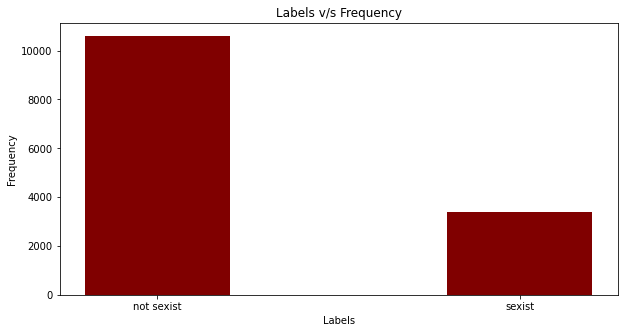

In [8]:
data = {'not sexist':10602, 'sexist':3398}
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.show()

**Dataset to Lists**

In [9]:
texts=df['text'].tolist()
labels=df['label_sexist'].tolist()
test_labels=dftest_labels['label'].tolist()

**Distibution of Numbers of words in each text**

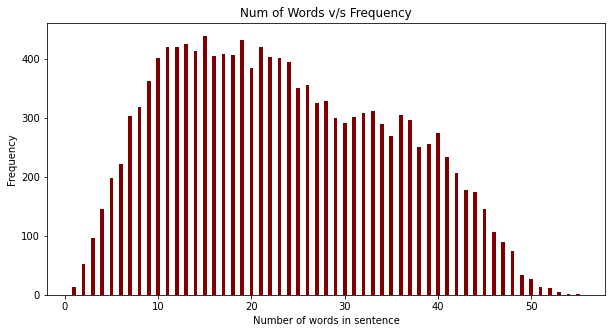

In [10]:
freq={}
for sentence in texts:
    num_text=len(sentence.split())
    if num_text not in freq:
        freq[num_text]=0
    freq[num_text]+=1

types = list(freq.keys())
frequency = list(freq.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Number of words in sentence")
plt.ylabel("Frequency")
plt.title("Num of Words v/s Frequency")
plt.show()

**Data Cleaning Modul** But not used

In [11]:
class DataCleaning():
    """
        Take a list of strings and preprocess strings, it preforms:
        
    """
    def __init__(self, list_data):
        self.data = list_data
        self.len = len(list_data)

    def clean_data(self):
        self.emojis_to_text()
        self.lowerCase()
        self.linkToTag()
        self.removePunctuations()
        self.removeWordsWithNumber()
        
    def tokenizer():
        pass
        
    def rootWord(self,lemmatizer=False):
        """
            Steamer is faster than lammatization.
            Steamer cut the last few words, and use the root word
            lemmatizer convert many form a word to the same word. 
            stemmer will retun 'car' for word 'caring'
            while lemmatizer return 'care' for 'caring'
        """
        if not lemmatizer:
            stemmer = PorterStemmer()
            for i in range(self.len):
                self.data[i]=" ".join([stemmer.stem(word) for word in self.data[i].split()])
        else:
            lemmatizer = WordNetLemmatizer()
            for i in range(self.len):
                self.data[i]=" ".join([lemmatizer.lemmatize(word) for word in self.data[i].split()])
        
    def removePunctuations(self):
        removePunc = re.compile(r'[^\w\s]')
        for i in range(self.len):
            self.data[i] = re.sub(removePunc, r" ",self.data[i])

    def emojis_to_text(self):
        """
            Converting image to its text meaning.
            Format: 👍 to ":thumbs_up:"
        """
        for i in range(self.len):
            self.data[i]=emoji.demojize(self.data[i])
            
    def linkToTag(self):
        """replacing web links with '<URL>'"""
        linkRegex = re.compile(r'\b(www|http|https)[^ |\n]*')

        for i in range(self.len):
            self.data[i] = re.sub(linkRegex, r"<URL>",self.data[i])
    
    def removeWordsWithNumber(self):
        """
            Zero or more number of non-whitespace then digit, 
            then Zero or more number of non-whitespace
        """
        wordNumRegex = re.compile(r'\S*\d\S*')
        for i in range(self.len):
            self.data[i]=re.sub(wordNumRegex,r"",self.data[i])
    
    def lowerCase(self):
        """
            It is sometimes important to keep the letter capital 
            as it signifies shouting in form of that word, but it
            depends on use case
        """
        for i in range(self.len):
            self.data[i]=self.data[i].lower()
            
    def removeStopword(self):
        """ Remove stopward from a string"""
        stop = stopwords.words('english')
        for i in range(self.len):
            self.data[i]=' '.join([word for word in self.data[i].split() if word not in stop])

In [12]:
#cleaning=DataCleaning(texts)
#cleaning.clean_data()
#texts=cleaning.data

**Loading Model**

In [13]:
# RoBERTa

preTrainedModel=True
roberta=""
roberta_tokenizer=""

if preTrainedModel == False:
    print('Loading Base model')
    roberta = RobertaModel.from_pretrained("roberta-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
    deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', use_fast=True, do_lower_case=False, max_len=64)
    deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
    
else:
    print("Loading Domain Adaptive Pretrained Model")
    modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt"
    roberta_tokenizer = RobertaTokenizer.from_pretrained(modelpath, use_fast = False, do_lower_case=True)
    roberta = RobertaModel.from_pretrained(modelpath)
    
    print("\n")
    
    deberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta"
    deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_modelpath, use_fast = False, do_lower_case=True)
    deberta = DebertaModel.from_pretrained(deberta_modelpath)
    
    

Loading Domain Adaptive Pretrained Model


Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt and are newly initialized: ['roberta.pooler.dense

Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta were not used when initializing DebertaModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Converting Train Data to Appropriate format**

In [14]:
MAX_LENGHT = 64
batch_size = 64

In [ ]:


texts=df['text'].tolist()#[:1000]
labels=df['label_sexist'].tolist()#[:1000]



testdata=dftest["text"].tolist()
test_labels

texts+=testdata
labels+=test_labels

#will encode list of text

tokens_train_roberta = roberta_tokenizer.batch_encode_plus(
    texts,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_train_deberta = deberta_tokenizer.batch_encode_plus(
    texts,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)


In [ ]:
train_seq_roberta = torch.tensor(tokens_train_roberta['input_ids'],device=device)
train_mask_roberta = torch.tensor(tokens_train_roberta['attention_mask'],device=device)

train_seq_deberta = torch.tensor(tokens_train_deberta['input_ids'],device=device)
train_mask_deberta = torch.tensor(tokens_train_deberta['attention_mask'],device=device)

# 1 for sexist and 0 for non sexist
y=[]
for label in labels:
    if label=="sexist":
        y.append(1)
    else:
        y.append(0)

train_y = torch.tensor(y,device=device)

In [ ]:
print(len(train_seq_roberta),len(train_mask_roberta),len(train_y))

In [ ]:

train_data = TensorDataset(train_seq_roberta, train_mask_roberta,train_seq_deberta, train_mask_deberta, train_y)    
train_sampler = RandomSampler(train_data)                    
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                            

In [15]:
for param in roberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed
    
for param in deberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed

**Model**

In [16]:
class RoBERT_Arch(nn.Module):
    def __init__(self, roberta,deberta):  
        super(RoBERT_Arch, self).__init__()
        self.roberta = roberta
        self.deberta = deberta
        self.dropout = nn.Dropout(0.1)            
        self.relu =  nn.ReLU()                    
        
        self.fc0 = nn.Linear(768*2,1024)
        self.fc1 = nn.Linear(1024,512)            
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,2)  
        
        self.softmax = nn.LogSoftmax(dim=1)       
    
    def forward(self, sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta):            
        cls_hs1 = self.roberta(sent_id_roberta, attention_mask=mask_roberta)
        cls_hs2 = self.deberta(sent_id_deberta, attention_mask=mask_deberta)
        
        hidden_state1 = cls_hs1[0]
        cls_hs1 = hidden_state1[:, 0]
        
        hidden_state2 = cls_hs2[0]
        cls_hs2 = hidden_state2[:, 0]
        
        x=torch.cat((cls_hs1,cls_hs2),1)
        
        x = self.fc0(x)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x) #Activation function,followed by dropout , in case of relu it is same
        x = self.dropout(x)
        x = self.fc2(x)    
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc4(x)
        x = self.softmax(x)      
        return x

model = RoBERT_Arch(roberta,deberta)
model= nn.DataParallel(model)
model = model.to(device)

**Hyperparameter**

In [ ]:
optimizer = AdamW(model.parameters(),lr = 1e-5)         
cross_entropy  = nn.NLLLoss() 
#cross_entropy = nn.CrossEntropyLoss()
epochs = 10

**Training**

In [ ]:
def train():  
    model.train()
    total_loss=0
  
    for step,batch in enumerate(tqdm(train_dataloader,position=0, leave=True)):          
        batch = [r for r in batch]                                  
        sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta, labels = batch 
        model.zero_grad()                                          
        preds = model(sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta).to(device)           
        
        loss = cross_entropy(preds, labels)   
        
        loss.backward()                                             
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
        optimizer.step()    
        total_loss = total_loss + loss.item()                    
     
    return total_loss 

#     for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
#         batch = [r for r in batch]                                  
#         sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta, labels = batch 
#         model.zero_grad()                                          
#         preds = model(sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta).to(device)           
        
#         loss = cross_entropy(preds, labels)   
        
#         loss.backward()                                             
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
#         optimizer.step()    
#         total_loss = total_loss + loss.item()                    
     
#     return total_loss 

In [17]:
MAX_LENGHT=64
#dftest = pd.read_csv(paths+'dev_task_a_entries.csv')
dftest = pd.read_csv(paths+'test_task_a_entries.csv')
testdata=dftest["text"].tolist()

tokens_val_roberta = roberta_tokenizer.batch_encode_plus(
    testdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_val_deberta = deberta_tokenizer.batch_encode_plus(
    testdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# 1 for sexist and 0 for non sexist
# ytest=[]
# for label in test_labels:
#     if label=="sexist":
#         ytest.append(1)
#     else:
#         ytest.append(0)

# len(ytest)

# Convert lists to tensors
val_seq_roberta = torch.tensor(tokens_val_roberta['input_ids'],device=device)
val_mask_roberta = torch.tensor(tokens_val_roberta['attention_mask'],device=device)

val_seq_deberta = torch.tensor(tokens_val_deberta['input_ids'],device=device)
val_mask_deberta = torch.tensor(tokens_val_deberta['attention_mask'],device=device)

#yT=torch.tensor(ytest,device=device)

val_data = TensorDataset(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta)    
#val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, batch_size=batch_size)



In [18]:
def check(c):

    with torch.no_grad():
        preds = model(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta)
        preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis = 1)
    #print("Test F1 score: ",f1_score(ytest,preds,average="macro"))
    
    label_pred=[]

    for val in preds:
        #print(val)
        if val==1:
            label_pred.append("sexist")
        else:
            label_pred.append("not sexist")
    

    dftest.drop(['text'], axis=1, inplace=True)
    dftest["label_pred"]=label_pred
    dftest.to_csv('prediction'+str(c)+'.csv', index=False)

In [ ]:
counter=0
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    total_loss = train()            
    print('Training Loss: ',total_loss)
    #check(counter)
    torch.save(model.state_dict(), 'Baseline+DPT+de+ro+'+str(counter)+".pt")
    counter+=1

In [19]:
path = "/kaggle/working/Baseline+DPT+de+ro+4.pt"
path = "/kaggle/input/explainable-detection-of-online-sexism/BaselineDPTdero4.pt"
model.load_state_dict(torch.load(path))
check(0)

**Save and Load Model**

In [ ]:
torch.save(model.state_dict(), 'Baseline+DPT.pt')

In [ ]:
path = './Baseline+DPT+de+ro+4.pt'
path = "/kaggle/input/explainable-detection-of-online-sexism/BaselineDPTdero4.pt"
model.load_state_dict(torch.load(path))

**F1 score for Test Data**

In [ ]:

preds=[]
with torch.no_grad():
    
    preds = model(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta)
    preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis = 1)
    print("Test F1 score: ",f1_score(ytest,preds,average="macro"))

label_pred=[]

for val in preds:
    #print(val)
    if val==1:
        label_pred.append("sexist")
    else:
        label_pred.append("not sexist")
    

#dftest.drop(['text'], axis=1, inplace=True)
dftest["label_pred"]=label_pred
dftest.to_csv('prediction.csv', index=False)

**Silver Labelling**

In [ ]:
dtf_mlm1 = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/gab_1M_unlabelled.csv')
dtf_mlm2 = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/reddit_1M_unlabelled.csv')
dtf_mlm=dtf_mlm1.append(dtf_mlm2)
print(dtf_mlm)
MAX_LENGHT = 64

silvertestdata=dtf_mlm["text"].tolist()[:300000]

tokens_silver_roberta = roberta_tokenizer.batch_encode_plus(
    silvertestdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
print("roberta tokenizer done")
tokens_silver_deberta = deberta_tokenizer.batch_encode_plus(
    silvertestdata,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

print("deberta tokenizer done")

# Convert lists to tensors
silver_seq_roberta = torch.tensor(tokens_silver_roberta['input_ids'],device=device)
silver_mask_roberta = torch.tensor(tokens_silver_roberta['attention_mask'],device=device)

silver_seq_deberta = torch.tensor(tokens_silver_deberta['input_ids'],device=device)
silver_mask_deberta = torch.tensor(tokens_silver_deberta['attention_mask'],device=device)

silver_data = TensorDataset(silver_seq_roberta, silver_mask_roberta,silver_seq_deberta, silver_mask_deberta)

In [ ]:
silver_dataloader = DataLoader(silver_data, batch_size=64)

In [ ]:
len(silver_dataloader)*64

In [ ]:
with torch.no_grad():
    c=0
    index=0
    dataset_text=[]
    dataset_label=[]
    
    for step,batch in enumerate(tqdm(silver_dataloader,position=0, leave=True)):          
        batch = [r for r in batch]                                  
        sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta = batch         
        preds = model(sent_id_roberta, mask_roberta, sent_id_deberta,mask_deberta).to(device)
        
        preds = preds.detach().cpu().numpy()
        
        for value in preds:
            if value[0]>value[1]:
                dataset_text.append(dtf_mlm["text"][index])
                dataset_label.append("not sexist")
            else:
                dataset_text.append(dtf_mlm["text"][index])
                dataset_label.append("sexist")
                
            index+=1
            

In [ ]:
df_silver = pd.DataFrame(
    dict(
        text=dataset_text,
        label_sexist=dataset_label
    )
)  
    
df_silver.to_csv('silver_labels.csv', index=False)

In [ ]:
print(len(dataset_text))

In [ ]:
predictions=[]

model.load_state_dict(torch.load("/kaggle/working/Baseline+DPT+de+ro1.pt"))

batch_size = 32                    
# val_data = TensorDataset(val_seq, val_mask)                   
# val_dataloader = DataLoader(val_data, batch_size=batch_size)

val_data = TensorDataset(val_seq_roberta, val_mask_roberta,val_seq_deberta, val_mask_deberta)    
#val_sampler = RandomSampler(val_data)                    
val_dataloader = DataLoader(val_data, batch_size=batch_size)

with torch.no_grad():

    for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
        batch = [r for r in batch]                                  
        sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta = batch         
        preds = model(sent_id_roberta, mask_roberta, sent_id_deberta,mask_deberta).to(device)
        
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis = 1)

        predictions+=preds.tolist()                         
    
f1=f1_score(ytest,predictions,average="macro")

In [ ]:
print(f1)

In [ ]:
len(predictions)
dftest

In [ ]:
print(f1)

In [ ]:
label_pred=[]

for val in predictions:
    if val==1:
        label_pred.append("sexist")
    else:
        label_pred.append("not sexist")
    

#dftest.drop(['text'], axis=1, inplace=True)
dftest["label_pred"]=label_pred


In [ ]:
dftest.to_csv('prediction.csv', index=False)

**F1 on Training Data**

In [ ]:
def eval():  

  with torch.no_grad():
    predictions=[]
  
    for step,batch in enumerate(tqdm(train_dataloader,position=0, leave=True)):          
      batch = [r for r in batch]                                  
      sent_id, mask, labels = batch         
      preds = model(sent_id, mask).to(device)           
      preds = torch.argmax(preds,dim=1)
      predictions+=preds.tolist()                         
    
    f1=f1_score(predictions,train_y.detach().cpu(),average="macro")

    pre=torch.Tensor(predictions).to(device)
    correct=0
    correct += (pre == train_y).sum().item()
    
    print(correct,"/",len(predictions))    
    print("Training F1 score: ",f1)

In [ ]:
eval()